## Imports

In [1]:
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import corner

# Plot parameters
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 30
matplotlib.rcParams['ytick.labelsize'] = 30
matplotlib.rcParams['xtick.major.size'] = 20
matplotlib.rcParams['ytick.major.size'] = 20
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['xtick.minor.size'] = 10
matplotlib.rcParams['ytick.minor.size'] = 10
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['legend.frameon'] = True
matplotlib.rcParams['lines.linewidth'] = 3

In [31]:
LabelDict = {'chirp_mass' : r"$\mathcal{M} [M_\odot]$", 'mass_ratio' : r"$q$", \
             'a_1' : r"$a_1$", 'a_2' : r"$a_2$", 'luminosity_distance' : r"$d_L$"}
    
def GetTruthDict(p):
    """ Return a dictionary of truth values from the parameters.json file 
        corresponding to the frames, where p is the path to the file """
    TruthDict = {}
    
    f = open(p + '/parameters.json')
    params = json.load(f)
    print(params)
    TruthDict['chirp_mass'] = params['chirp_mass']
    TruthDict['mass_ratio'] = params['mass_ratio']
    TruthDict['luminosity_distance'] = params['dist_mpc']
    TruthDict['a_1'] = params['a_1'][2] ## assumes aligned spin for now
    TruthDict['a_2'] = params['a_2'][2]
    f.close()
    return TruthDict

def Evidence(p):
    """ Return the log evidence from a given bilby run """
    f = open(p + '/fast_tutorial_result.json')
    data = json.load(f)
    f.close()
    return data['log_evidence']

def EvidenceErr(p):
    """ Return the error on the log evidence from a given bilby run """
    f = open(p + '/fast_tutorial_result.json')
    data = json.load(f)
    f.close()
    return data['log_evidence_err']

def BayesFactor(p):
    """ Return the log Bayes factor form a given bilby run """
    f = open(p + '/fast_tutorial_result.json')
    data = json.load(f)
    f.close()
    return data['log_bayes_factor']

def GetPosterior(p, quantity):
    """ Return the posterior for a given bilby run
        for a given quantity, such as mass_ratio, 
        chirp_mass, a_1, a_2, etc"""
    f = open(p + '/fast_tutorial_result.json')
    data = json.load(f)
    vals = data['posterior']['content'][quantity]
    f.close()
    return vals

In [7]:
def PlotEvidences():
    
    def evaluate(p):
        
        ev = Evidence(p)
        ev_err = EvidenceErr(p)
        bf = BayesFactor(p)
        print(ev, ev_err, bf)
        
    
    evaluate('../BilbyPE/Surrogate_FramesProcs/outdir')
    evaluate('../BilbyPE/Surrogate_FramesCloser/outdir')

In [184]:
def PlotMassRatioPosteriors():
    
    def histogram(p, label, color):
        data = GetPosterior(p, 'mass_ratio')
        nbins = 20
        H = plt.hist(data, alpha=1.0, color = color, linewidth=2.0, histtype=u'step', density=True, bins = nbins, label=p)
        
    plt.figure(figsize=(10,6))
    
    cs = sns.color_palette('Paired', n_colors=5)
    histogram('../BilbyPE/Surrogate_FramesSearch/outdir', 'reg', cs[0])
    histogram('../BilbyPE/Surrogate_FramesSearch25Hz/outdir', 'with spin', cs[1])
    histogram('../BilbyPE/Surrogate_FramesSearchNoise/outdir', 'closer', cs[2])
    #histogram('../BilbyPE/Surrogate_FramesMass/outdir', 'just masses', cs[3])
    
    plt.legend(loc='best', ncol=1, fontsize=18)
    plt.ylabel('Posterior distribution')
    plt.xlabel('$q$')
    plt.tight_layout()
    plt.show()

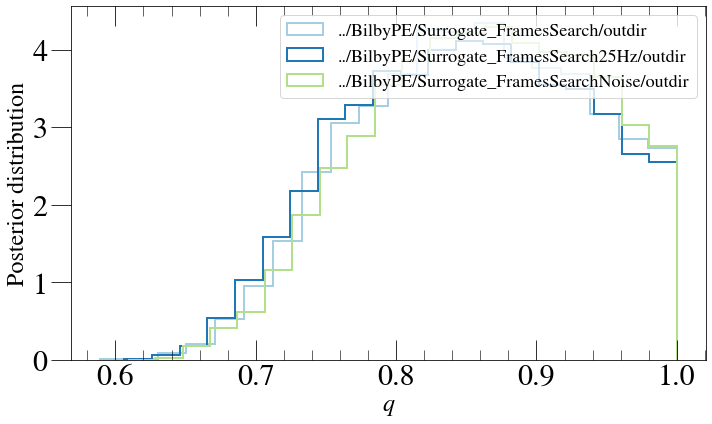

In [185]:
PlotMassRatioPosteriors()

{'mass_ratio': 0.8188310079446952, 'dt': 0.00048828125, 't_gps': 1126259462.0, 'peak_time_in_segment': 8.0, 'segment_length': 16.0, 'dist_mpc': 400.0, 'chirp_mass': 29.422167356249002, 'mass': 68.0, 'q': 1.2212532137858916, 'a_1': [0, 0, 0.329892752405], 'a_2': [0, 0, -0.439940981499], 'f_low': 0, 'theta': 3.141592653589793, 'phi': 0, 'ra': 1.952318922, 'dec': -1.26967171703, 'pol': 0.824043851821}


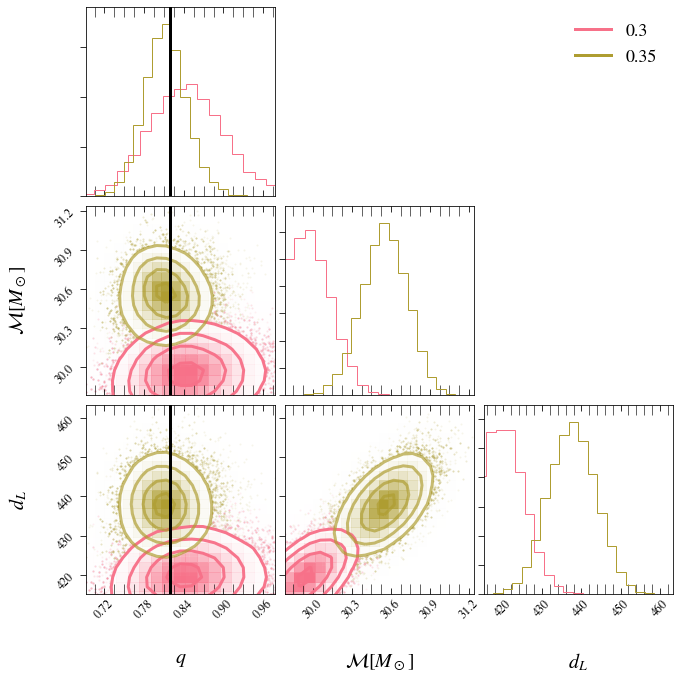

In [32]:
def CornerPlot():
    
    quants = ['mass_ratio', 'chirp_mass', 'luminosity_distance'] #, 'a_1', 'a_2']
    labels = [LabelDict[q] for q in quants]
    
    p1 = '../BilbyPE/dCS_0p3/'
    TruthDict1 = GetTruthDict('../BilbyPE/NR_Frames/Frames_NR') ## for now
    truths1 = [TruthDict1[q] for q in quants]
    vals1 = np.vstack([GetPosterior(p1 + 'outdir', q) for q in quants]).transpose()
    
    p2 = '../BilbyPE/dCS_0p35/'
    #TruthDict2 = GetTruthDict(p1 + 'Frames_NR')
    #truths2 = [TruthDict2[q] for q in quants]
    vals2 = np.vstack([GetPosterior(p2 + 'outdir', q) for q in quants]).transpose()
    
    cs = sns.color_palette('husl', n_colors=5)
    
    ranges = [1.0 for d in labels]
    dim = len(quants) 
    
    fig, ax_arr = plt.subplots(dim, dim, figsize=(10,10))

    corner.corner(vals1, fig=fig, labels=labels,
                       title_kwargs={"fontsize": 20}, label_kwargs={"fontsize": 20}, color=cs[0], 
                       show_titles=False, truths = truths1, truth_color = 'black', smooth = 1.0,)
    corner.corner(vals2, fig=fig, labels=labels,
                      title_kwargs={"fontsize": 18}, label_kwargs={"fontsize": 20}, color=cs[1], 
                      show_titles=False, smooth = 1.0)

    ## add in the legend
    x = [0.0, 0.0]
    y = [0.0, 0.0]
    l1 = ax_arr[0][dim-1].plot(x, y, label='0.3', color = cs[0])
    l2 = ax_arr[0][dim-1].plot(x, y, label='0.35', color = cs[1])
    legend = ax_arr[0][dim-1].legend(handles=[l1[0], l2[0]], frameon=False)
    plt.setp(legend.get_title(),fontsize=20)

    for ax in fig.get_axes():
        ax.tick_params(axis='both', labelsize=12, length=6)
    plt.savefig('BilbySurrogate.pdf')
    plt.show()
    
CornerPlot()  